# Commands

In [1]:
# ! pip install git+git://github.com/target/matrixprofile-ts#installation

In [2]:
# %%time
# %%capture
# ! pip install git+https://github.com/rob-med/owlpy

# Import

In [3]:
import matplotlib.pyplot as plt # grafikams
import numpy as np # skaičiavimams
import time

In [4]:
%%time
%%capture

# Grafikams
import mir_eval.display 
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

# Notebook audio player
import IPython.display


# Analizės įrankiai
from scipy import signal
from scipy.io import wavfile


Wall time: 1.53 s


# Read A, B

In [5]:
sample_rateA, samplesA = wavfile.read('audio/Debussy_Wagner - The Flying Dutchman Overture (for 2 pianos).wav')
sample_rateB, samplesB = wavfile.read('audio/Wagner - Flying Dutchman - Overture-HqezCR_XzaI.wav')

# sample_rate ---- sampling frequancy, muzikos formato dažnis, (kiek skaičių per sekundę reprezentuoja garsą)
# data --- garso takelis, [stereo :> du takeliai]

In [6]:
sample_rateA, sample_rateB
sample_rate = sample_rateA

In [7]:
sample_rate

48000

In [8]:
# pasiklausome pirmas 10s įrašo
# IPython.display.Audio(samplesA[: sample_rateA*10, 0], rate=sample_rateA) # play 10% of the track

# Mel spektrograma

In [9]:
stft_hop = int(sample_rate * 23 / 1000) # 23 ms

In [10]:
def get_mel_spectrogram(samples, sample_rate=48000):
    # Furje transformacijos laiko langas.
    stft_window = int(sample_rate * 46 / 1000) # 46 ms

    # FT laiko lango žingsnis
    stft_hop = int(sample_rate * 23 / 1000) # 23 ms


    mel_filters = 32  #  -- tipo gal čia yra dažnių interavalas  :D ?

    #  Mel-spectrogram  is 
    # extracted with the following parameters, which are commonly 
    # used  in  MIR:  46  milliseconds  short  time  Fourier  transform 
    # (STFT) window, 23 milliseconds STFT hop, and 32 Mel-scale 
    # triangular filters. 


    mel = librosa.feature.melspectrogram(
                                         y=samples[::,1],
                                         sr=sample_rate,
                                         n_fft=stft_window,
                                         hop_length=stft_hop,
                                         n_mels = mel_filters
                                        )
    return mel

In [11]:
mel_A = get_mel_spectrogram(samplesA)
mel_B = get_mel_spectrogram(samplesB)

In [12]:
def plot_mel_spectrogram(mel, stft_hop=stft_hop, sample_rate=48000):
    plt.figure(figsize = (15,5))
    eps = np.finfo(np.float32).eps # machine epsilon


    t = np.linspace(0, stft_hop / sample_rate * mel.shape[1] / 60, mel.shape[1])
    freqs = np.linspace(1, 32, 32)
    # Time, Freqs = np.meshgrid(t, freqs)

    plt.pcolormesh(t, freqs, np.log(mel[:,: ] + eps), cmap='jet')

    plt.colorbar()
    # plt.imshow(spectrogram)
    plt.ylabel('Dažnis, s.v.')
    plt.xlabel('Laikas, min.')
    plt.title('Mel spektrograma (log mastelis)')
    plt.show()

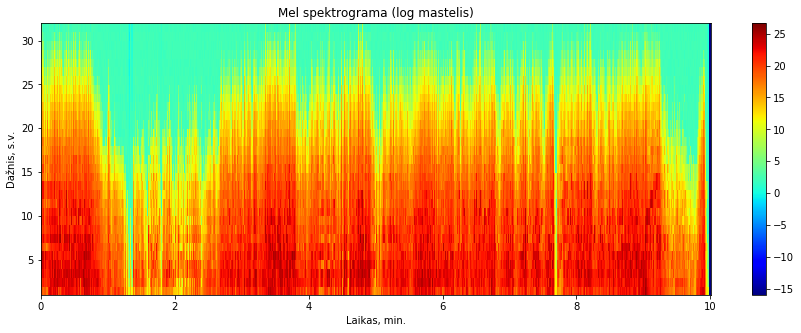

In [13]:
plot_mel_spectrogram(mel_A)

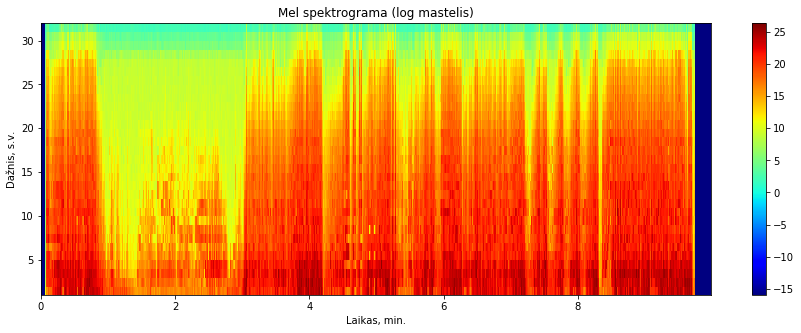

In [14]:
plot_mel_spectrogram(mel_B)

# Motyvų paieška

Naudojame laiko eilutės motyvų paieškos algoritmą:

1. Chin-Chia Michael Yeh, Yan Zhu, Liudmila Ulanova, Nurjahan Begum, Yifei Ding, Hoang Anh Dau, Diego Furtado Silva, Abdullah Mueen, Eamonn Keogh (2016). Matrix Profile I: All Pairs Similarity Joins for Time Series: A Unifying View that Includes Motifs, Discords and Shapelets. IEEE ICDM 2016

2. Matrix Profile II: Exploiting a Novel Algorithm and GPUs to break the one Hundred Million Barrier for Time Series Motifs and Joins. Yan Zhu, Zachary Zimmerman, Nader Shakibay Senobari, Chin-Chia Michael Yeh, Gareth Funning, Abdullah Mueen, Philip Berisk and Eamonn Keogh (2016). EEE ICDM 2016

3. Matrix Profile V: A Generic Technique to Incorporate Domain Knowledge into Motif Discovery. Hoang Anh Dau and Eamonn Keogh. KDD'17, Halifax, Canada.

Naudojame šio algoritmo įgyvendinimą atviro kodo python pakete: https://github.com/target/matrixprofile-ts

In [15]:
# Importuojame reikalingus python paketus
# todo: comment
import scipy.io as sio

In [16]:
stft_hop / sample_rate # one step trukme [s]

0.023

In [17]:
def get_audio_idx(spectrogram_idx, stft_hop, sample_rate):
    '''
    Purpose: return index of music time series that correspond to specific
             Mel Spectrogram time index.
    '''
    return spectrogram_idx * stft_hop

In [18]:
sub_len = 218 # 5s trukmė mel spektrogramos žingsniais

## Apskaičiuojame Mel spektrogramos "matrix profile": motyvų paieška

In [19]:
def seconds_to_steps(t):
    '''
    Return number of Mel spectrogram steps
    for a number of seconds
    '''
    return int(218/5 * t)

In [20]:
seconds_to_steps(20)

872

In [21]:
m = 218*4 # 20s

In [22]:
m

872

In [23]:
from core import *

In [24]:
# import matrixprofile

# from matrixprofile.matrixProfile import stmp, stomp

In [25]:
def get_m_profile(A, B, m):
    '''
    A --- time series 1
    B --- time series 2
    m --- motif length 
    '''
    matrix_profile, mpIndex = stamp(A, B, m)
#     matrix_profile, mpIndex = stomp(A, m, tsB=B)
#     MP, I = stamp(ts,query,15)
    
    return matrix_profile, mpIndex

In [26]:
mel_A.shape

(32, 26096)

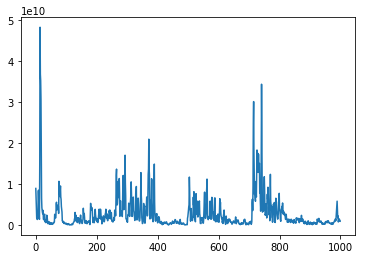

In [27]:
plt.plot(mel_A[10, 1000:2000])

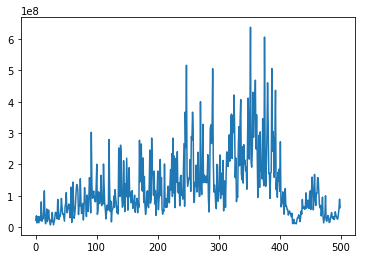

In [28]:
plt.plot(mel_B[15, 500:1000])

In [38]:
matrix_profile, mpIndex = get_m_profile(mel_A[10, 1000:2000], mel_A[10, 1000:2000], 400)

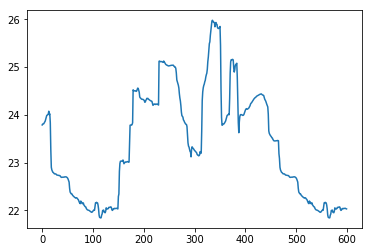

In [39]:
plt.plot(matrix_profile)

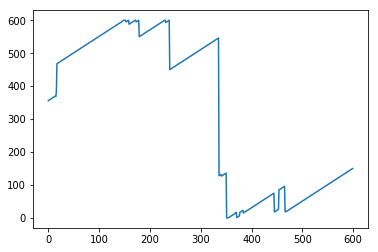

In [40]:
plt.plot(mpIndex)

In [31]:
Pab, Iab = stomp(mel_A[10, 1000:2000], 400)

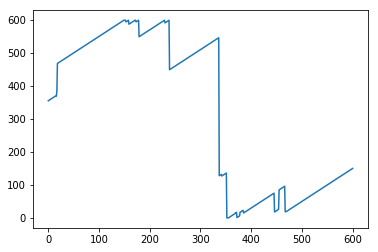

In [32]:
plt.plot(Iab)

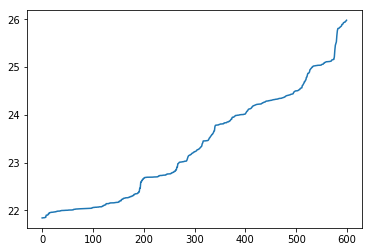

In [33]:
plt.plot(np.sort(matrix_profile))

# Filtering

In [55]:
def top_motifs(matrix_profile, mpIndex, N, min_distance=0):
    '''
    matrix_profile --- matrix profile (difference measure)
    mpIndex       --- matrix profile index
    N  --- number of motifs
    min_discante --- minimal distance from motifs in time series steps
                    may be 0 for different tracks comparison
    '''
    idx_1_ = np.argsort(matrix_profile) # ascending order
    idx_2_ = mpIndex[idx_1_]
    
    # lists for selected motifs
    idx_1 = []
    idx_2 = []
    distanceL2 = []
    
    # select the motifs
    for n in range(N):        
        if np.abs(idx_1_[n] - idx_2_[n]) > min_distance:
            # Select only motifs that are enough far away
            idx_1.append( int(idx_1_[n]) )
            idx_2.append( int(idx_2_[n]) )
            distanceL2.append( matrix_profile[idx_1_[n]])
        
    
    return idx_1, idx_2, distanceL2
        


In [56]:
idx_1, idx_2, distanceL2 = top_motifs(matrix_profile, mpIndex, N=500, min_distance=0)

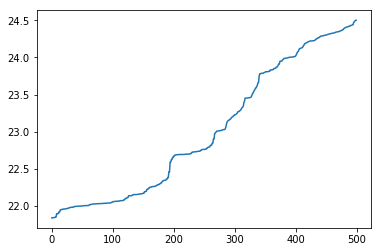

In [57]:
plt.plot(distanceL2)

In [58]:
idx_1[0]

115

In [59]:
idx_2[0]

566

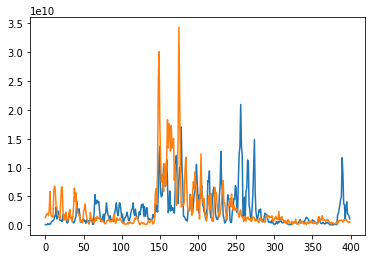

In [60]:
plt.plot(mel_A[10, 1000:2000][idx_1[0]:idx_1[0]+400])
plt.plot(mel_A[10, 1000:2000][idx_2[0]:idx_2[0]+400])